**Remarks**

In this notebook, we will learn about IMDB-movie-review using word2Vec. Yeayy! I will show to download kaggle into your notebook. Let's started!

In [ ]:
!python -m spacy download en_core_web_lg

In [3]:
# import library
# 1. dataframe environment
import numpy as np 
import pandas as pd

# 2. NLP tools
import spacy
import en_core_web_lg
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import re
from bs4 import BeautifulSoup
import unicodedata
from textblob import TextBlob

# 3. Modelling tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# 4. Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
# preparing dataset from KAGGLE
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 93% 24.0M/25.7M [00:00<00:00, 47.6MB/s]
100% 25.7M/25.7M [00:00<00:00, 102MB/s] 


In [6]:
# unzipping dataset
!unzip "imdb-dataset-of-50k-movie-reviews.zip"

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [8]:
df = pd.read_csv('IMDB Dataset.csv', sep=',')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [21]:
# preparing modelling NLP
nlp = en_core_web_lg.load()

In [10]:
# function NLP, you can check in materi 02
def get_wordcounts(x):
  length = len(str(x).split())
  return length

def get_charcounts(x):
  s = x.split()
  x = ''.join(s)
  return len(x)

def get_avg_wordlength(x):
	count = get_charcounts(x)/get_wordcounts(x)
	return count

def get_stopwords_counts(x):
	l = len([t for t in x.split() if t in stopwords])
	return l

def get_hashtag_counts(x):
	l = len([t for t in x.split() if t.startswith('#')])
	return l

def get_mentions_counts(x):
	l = len([t for t in x.split() if t.startswith('@')])
	return l

def get_digit_counts(x):
	digits = re.findall(r'[0-9,.]+', x)
	return len(digits)

def get_digit_counts(x):
	digits = re.findall(r'[0-9,.]+', x)
	return len(digits)

def get_uppercase_counts(x):
  x = len([t for t in x.split() if t.isupper()])
  return x

def get_emails(x):
	emails = re.findall(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+\b)', x)
	counts = len(emails)

	return counts, emails


def get_urls(x):
	urls = re.findall(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', x)
	counts = len(urls)

	return counts, urls

def make_base(x):
	x = str(x)
	x_list = []
	doc = nlp(x)
	
	for token in doc:
		lemma = token.lemma_
		if lemma == '-PRON-' or lemma == 'be':
			lemma = token.text

		x_list.append(lemma)
	return ' '.join(x_list)

def get_value_counts(df, col):
	text = ' '.join(df[col])
	text = text.split()
	freq = pd.Series(text).value_counts()
	return freq

def spelling_correction(x):
	x = TextBlob(x).correct()
	return x

def get_basic_features(df):
	if type(df) == pd.core.frame.DataFrame:
		df['char_counts'] = df['text'].apply(lambda x:get_charcounts(x))
		df['word_counts'] = df['text'].apply(lambda x:get_wordcounts(x))
		df['avg_wordlength'] = df['text'].apply(lambda x:get_avg_wordlength(x))
		df['stopwords_counts'] = df['text'].apply(lambda x:get_stopwords_counts(x))
		df['hashtag_counts'] = df['text'].apply(lambda x:get_hashtag_counts(x))
		df['mentions_counts'] = df['text'].apply(lambda x:get_mentions_counts(x))
		df['digits_counts'] = df['text'].apply(lambda x:get_digit_counts(x))
		df['uppercase_counts'] = df['text'].apply(lambda x:get_uppercase_counts(x))
	else:
		print('ERROR: This function takes only Pandas DataFrame')

In [15]:
# function NLP, you can check in materi 02
def remove_urls(x):
  y = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)
  return y

def remove_emails(x):
  y = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)
  return y

def remove_rt(x):
  y = re.sub(r'\brt\b', '', x).strip()
  return y

def remove_special_chars(x):
	x = re.sub(r'[^\w ]+', "", x)
	x = ' '.join(x.split())
	return x

def remove_html_tags(x):
  y = BeautifulSoup(x, 'lxml').get_text().strip()
  return y

def remove_accented_chars(x):
	x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
	return x

def remove_stopwords(x):
  y = ' '.join([t for t in x.split() if t not in stopwords])
  return y

def remove_common_words(x, freq, n=20):
	fn = freq[:n]
	x = ' '.join([t for t in x.split() if t not in fn])
	return x

def remove_rarewords(x, freq, n=20):
	fn = freq.tail(n)
	x = ' '.join([t for t in x.split() if t not in fn])
	return x

def remove_dups_char(x):
	x = re.sub("(.)\\1{2,}", "\\1", x)
	return x

In [19]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = remove_emails(x)
    x = remove_urls(x)
    x = remove_html_tags(x)
    x = remove_rt(x)
    x = remove_accented_chars(x)
    x = remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    x = make_base(x)
    x = remove_stopwords(x)
    make_base
        
    return x

In [22]:
# cleaning data
df['review'] = df['review'].apply(lambda x:get_clean(x))
df.head()

,review,sentiment
0,reviewer mention watch 1 oz episode hook right...,positive
1,wonderful little production filming technique ...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically s family little boy jake think s zom...,negative
4,petter matteis love time money visually stunni...,positive


In [23]:
# word2vec conversion 
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

df['vec'] = df['review'].apply(lambda x: get_vec(x))
df.head()

,review,sentiment,vec
0,reviewer mention watch 1 oz episode hook right...,positive,"[-0.11349001, 0.07763749, -0.015776152, 0.0279..."
1,wonderful little production filming technique ...,positive,"[-0.01947566, 0.09256802, -0.049783204, 0.0453..."
2,think wonderful way spend time hot summer week...,positive,"[-0.042142764, 0.13432778, -0.0149775315, -0.0..."
3,basically s family little boy jake think s zom...,negative,"[-0.071977355, -0.022413105, -0.08308465, -0.0..."
4,petter matteis love time money visually stunni...,positive,"[0.011353568, 0.10316405, -0.121876426, -0.086..."


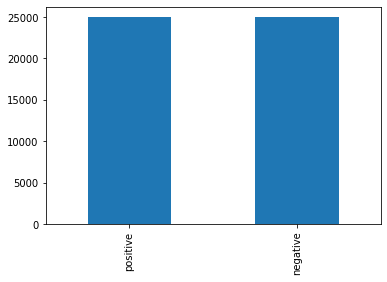

In [27]:
# showing number of sentiment
df.sentiment.value_counts().plot(kind='bar');

In [28]:
# splitting data
X = df['vec'].to_numpy()
X = X.reshape(-1,1) # tranphose
X.shape

(50000, 1)

In [29]:
# contatenating data
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1,300)

In [32]:
X.shape
y = df['sentiment']

In [33]:
# splitting train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Number of Training: {}, Number of Testing: {}".format(X_train.shape, X_test.shape))

Number of Training: (40000, 300), Number of Testing: (10000, 300)


In [34]:
# building classifier
clf = LogisticRegression(solver='saga')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
# predicting data
y_pred = clf.predict(X_test)

In [36]:
# evaluation model
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}%".format(round((accuracy_score(y_test,y_pred)*100),2)))
print(classification_report(y_test,y_pred))

[[4162  799]
 [ 762 4277]]
Accuracy Score 84.39%
              precision    recall  f1-score   support

    negative       0.85      0.84      0.84      4961
    positive       0.84      0.85      0.85      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [37]:
# changing model
clf=LinearSVC(class_weight='balanced')
clf.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [38]:
y_pred=clf.predict(X_test)

In [39]:
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}%".format(round((accuracy_score(y_test,y_pred)*100),2)))
print(classification_report(y_test,y_pred))

[[4160  801]
 [ 755 4284]]
Accuracy Score 84.44%
              precision    recall  f1-score   support

    negative       0.85      0.84      0.84      4961
    positive       0.84      0.85      0.85      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [40]:
# testing new text
def pred(msg):
  msg=get_clean(msg)
  vec=get_vec(msg)
  prediction = clf.predict(vec.reshape(1, -1))
  return print(prediction)

In [50]:
# testing new text
def pred(msg):
  msg=get_clean(msg)
  vec=get_vec(msg)
  prediction = clf.predict(vec.reshape(1, -1))
  return prediction[0]

In [51]:
pred("I think the actor doesn't deserve well")

'negative'

In [47]:
# saving model
joblib.dump(clf, '../content/review-model.pkl', compress=3)

['../content/review-model.pkl']

In [ ]:
# created model in FLASK
# install apropriate tools
!pip install flask-restplus
!pip install flask_ngrok

In [46]:
from flask import Flask
from flask_ngrok import run_with_ngrok
import werkzeug
werkzeug.cached_property = werkzeug.utils.cached_property
from flask_restplus import Api, Resource, fields
from sklearn.externals import joblib
import pandas as pd

In [53]:
# create API
app = Flask(__name__)
run_with_ngrok(app)
api = Api(
    app,
    version='1.0',
    title='Film Review Prediction Sentiment',
    description='Sentiment API'
)

ns = api.namespace('Prediction',
                   description='This is app to know sentiment review')

parser = api.parser()

parser.add_argument(
    'REVIEW',
    type=str,
    required=True, 
    help='Review to be analyzed',
    location='args'
)

resource_fields = api.model('Resource', {
    'The result': fields.String,
})

In [54]:
# load model to FLASK
clf = joblib.load('../content/review-model.pkl')

@ns.route('/')
class ReviewAPI(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        result = self.predict_proba(args)
      
        return result, 200
  
    def predict_proba(self, args):
        message = args["REVIEW"]
        message_ = pd.DataFrame([message], columns=['message'])
      
        msg=get_clean(message)
        vec=get_vec(msg)
        prediction = clf.predict(vec.reshape(1, -1))
        return {
            "The result" : prediction[0]
        }

In [ ]:
if __name__ == '__main__':
    app.run()